# Time Series Models

In [ ]:
!pip install pmdarima

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [4]:
data_clen = 'https://raw.githubusercontent.com/Ly-Ax/RetailML/main/data/clean/coffee_shop_clean.csv'
num_days = 30

## Split Data

In [52]:
df = pd.read_csv(data_clen)

df = df[['trn_date', 'total_bill']]
df.columns = ['daily','sales']

df.daily = pd.to_datetime(df.daily)
df = df.groupby('daily')['sales'].sum().reset_index()

df.iloc[[0,-1]]

,daily,sales
0,2023-01-01,2508.20
180,2023-06-30,5481.32


In [55]:
df_train = df.iloc[:-num_days]
df_test = df.iloc[-num_days:]

print(f'Train range: {str(df_train.daily.min())[0:10]} to {str(df_train.daily.max())[0:10]}')
print(f'Test range:  {str(df_test.daily.min())[0:10]} to {str(df_test.daily.max())[0:10]}')

Train range: 2023-01-01 to 2023-05-31
Test range:  2023-06-01 to 2023-06-30


## Auto ARIMA

In [57]:
arima_train = df_train.copy()
arima_test = df_test.copy()

In [58]:
arima_train.set_index(arima_train.daily, inplace=True)
arima_train.drop(columns=['daily'], inplace=True)
arima_train.head(2)

,sales
daily,
2023-01-01,2508.20
2023-01-02,2403.35


In [59]:
arima_test.set_index(arima_test.daily, inplace=True)
arima_test.drop(columns=['daily'], inplace=True)
arima_test.head(2)

,sales
daily,
2023-06-01,5227.0
2023-06-02,5056.5


### Analysis

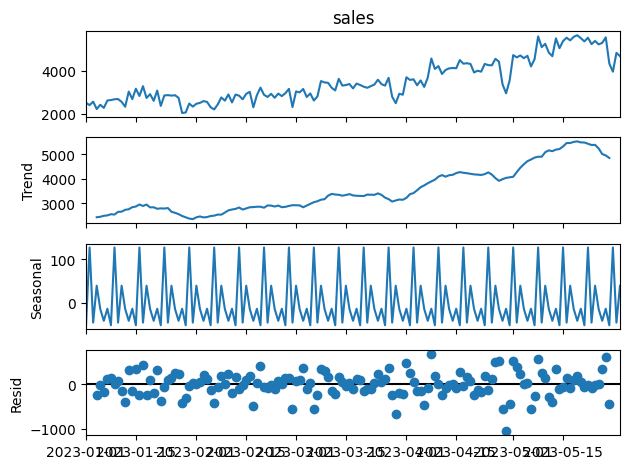

In [65]:
sd_sales = seasonal_decompose(arima_train.sales, model='add')
sd_sales.plot();

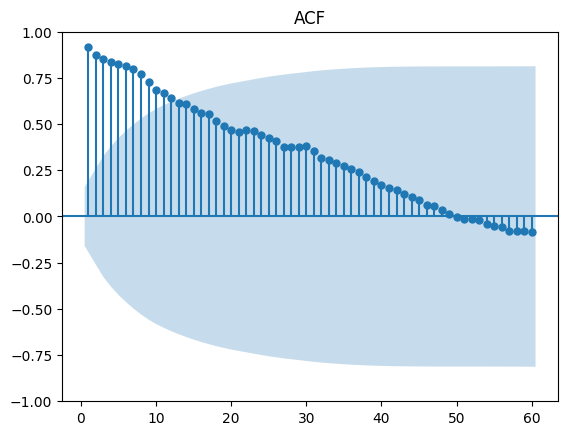

In [73]:
plot_acf(arima_train.sales, lags=60, zero=False)
plt.title('ACF')
plt.show()

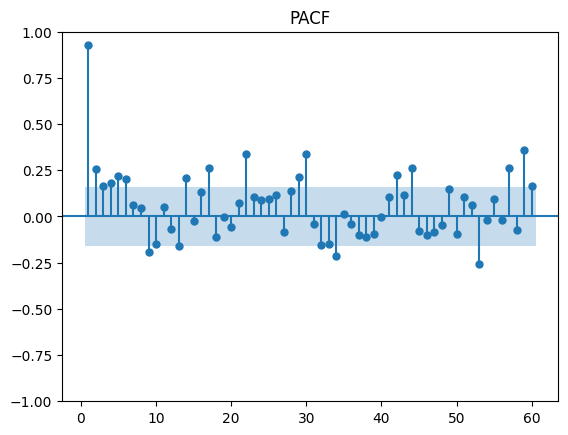

In [74]:
plot_pacf(arima_train.sales, lags=60, zero=False, method='ols')
plt.title('PACF')
plt.show()

### Training

In [79]:
model_auto = auto_arima(arima_train)
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  151
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1087.697
Date:                Wed, 24 Apr 2024   AIC                           2183.394
Time:                        01:59:22   BIC                           2195.437
Sample:                    01-01-2023   HQIC                          2188.287
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.6339      5.573      1.908      0.056      -0.289      21.557
ar.L1          0.3710      0.122      3.036      0.002       0.131       0.611
ma.L1         -0.8118      0.089     -9.120      0.000      -0.986      -0.637
sigma2       1.16e+05   9544.296     12.154      0.000    9.73e+04    1.35e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                32.04
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -0.29
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [81]:
arima_pred = pd.DataFrame(model_auto.predict(n_periods=num_days), index=arima_test.index)

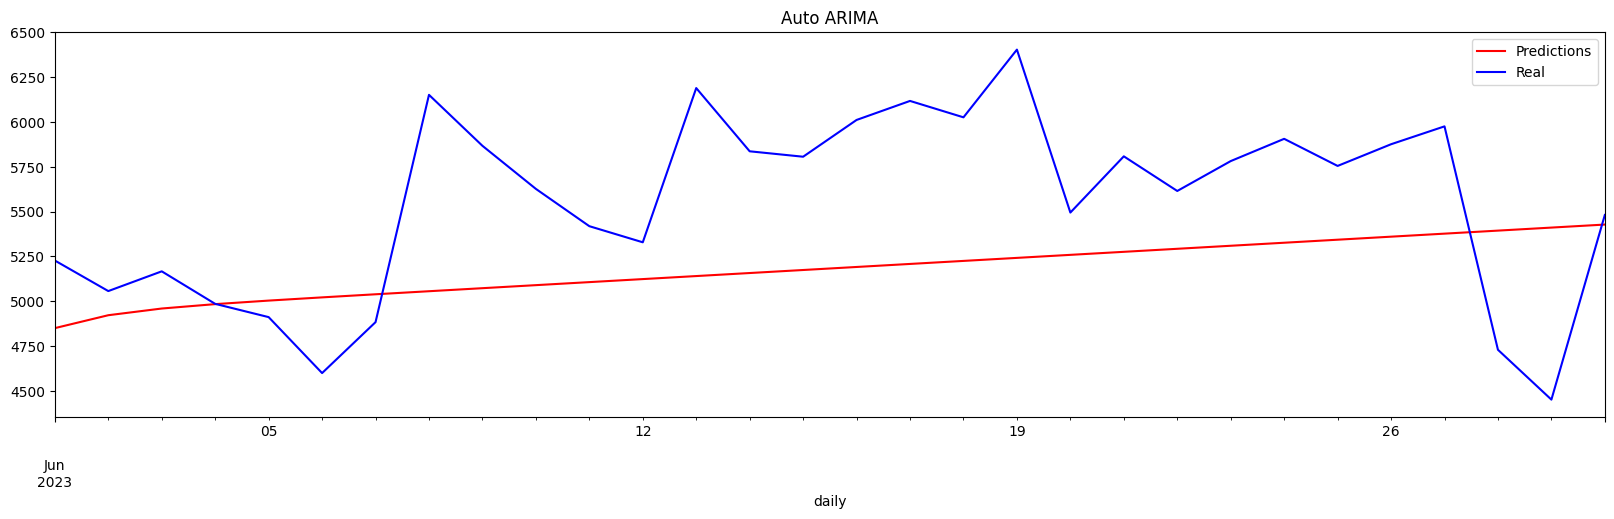

In [82]:
arima_pred.plot(figsize=(20,5), color='red')
arima_test.sales.plot(color='blue')

plt.title('Auto ARIMA')
plt.legend(['Predictions','Real'])
plt.show()

### Configuring

In [92]:
model_auto = auto_arima(arima_train, start_p=1, start_q=1, max_p=30, max_q=30,
                        max_order=None, start_P=1, start_Q=0, m=10, d=0, D=1)
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  151
Model:             SARIMAX(2, 0, 1)x(2, 1, [1, 2], 10)   Log Likelihood               -1025.018
Date:                                 Wed, 24 Apr 2024   AIC                           2068.035
Time:                                         02:24:49   BIC                           2094.574
Sample:                                     01-01-2023   HQIC                          2078.820
                                          - 05-31-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     47.2294     30.863      1.530      0.126     -13.261     107.720
ar.L1          0.8837      0.192      4.606      0.000       0.508       1.260
ar.L2          0.0131      0.142      0.092      0.926      -0.265       0.291
ma.L1         -0.5263      0.192     -2.743      0.006      -0.902      -0.150
ar.S.L10      -0.6866      0.178     -3.858      0.000      -1.035      -0.338
ar.S.L20      -0.4363      0.075     -5.855      0.000      -0.582      -0.290
ma.S.L10      -0.4432      0.202     -2.198      0.028      -0.838      -0.048
ma.S.L20      -0.3701      0.229     -1.615      0.106      -0.819       0.079
sigma2      9.811e+04   1.28e+04      7.645      0.000     7.3e+04    1.23e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.58   Prob(JB):                         0.73
Heteroskedasticity (H):               1.67   Skew:                            -0.01
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
arima_pred = pd.DataFrame(model_auto.predict(n_periods=num_days), index=arima_test.index)

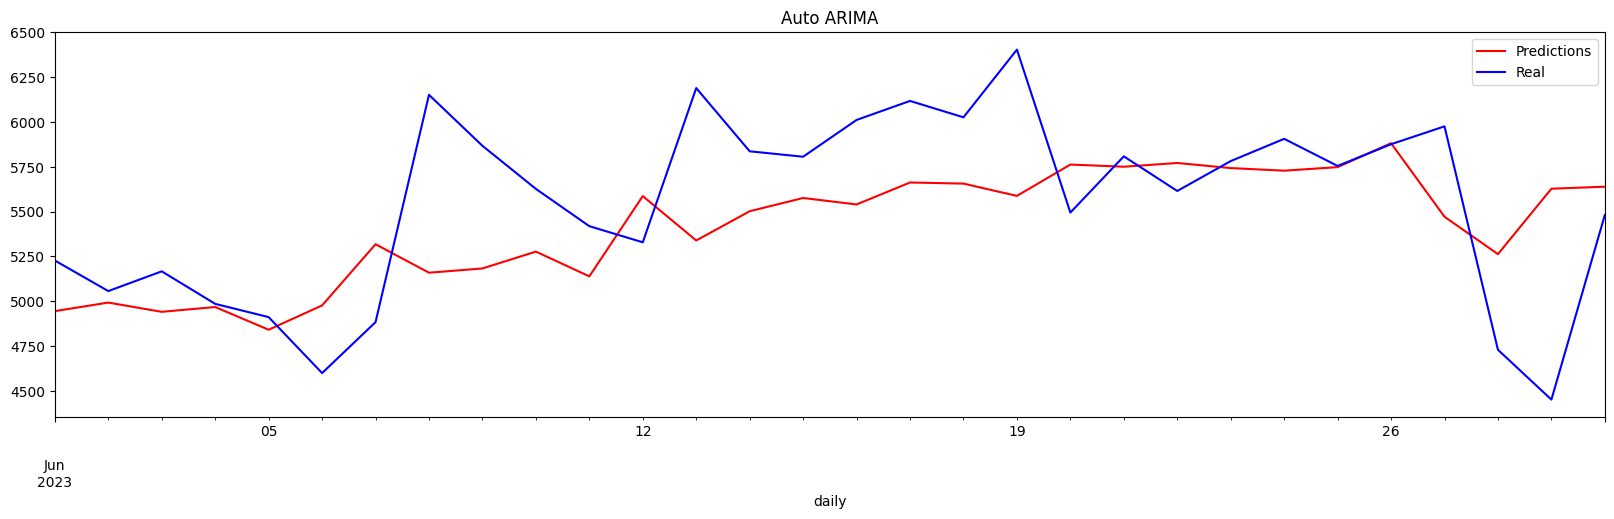

In [94]:
arima_pred.plot(figsize=(20,5), color='red')
arima_test.sales.plot(color='blue')

plt.title('Auto ARIMA')
plt.legend(['Predictions','Real'])
plt.show()

## SARIMA

In [140]:
model_sarima = SARIMAX(arima_train, order=(2,0,1), seasonal_order=(1,1,1,12))
results_sarima = model_sarima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [141]:
sarima_pred = results_sarima.predict(start=df_test.daily.min(), end=df_test.daily.max())

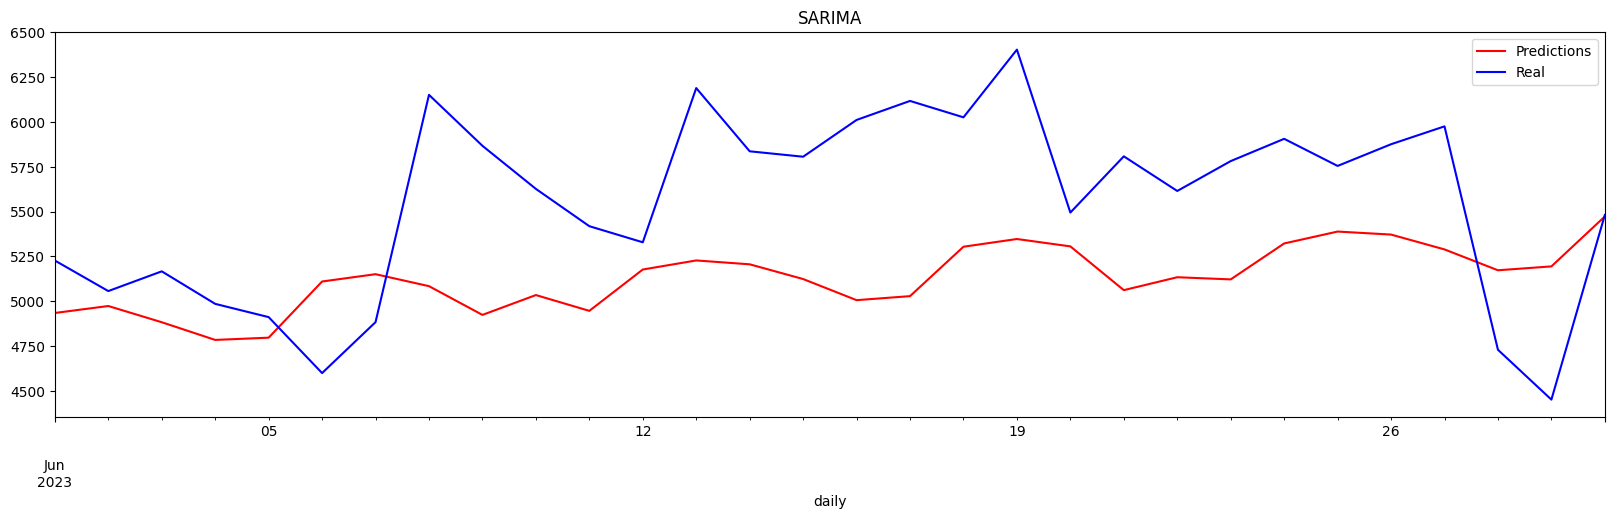

In [142]:
sarima_pred.plot(figsize=(20,5), color='red')
arima_test.sales.plot(color='blue')

plt.title('SARIMA')
plt.legend(['Predictions','Real'])
plt.show()

## Prophet

## Results

### Comparison

In [147]:
predictions = pd.DataFrame(arima_pred.values, columns=['autoarima'], index=arima_test.index)
predictions['sarima'] = sarima_pred.values
predictions['test'] = arima_test.sales
predictions.head(3)

,autoarima,sarima,test
daily,,,
2023-06-01,4944.692369,4934.303535,5227.00
2023-06-02,4992.286965,4973.125978,5056.50
2023-06-03,4940.721061,4882.647122,5166.65


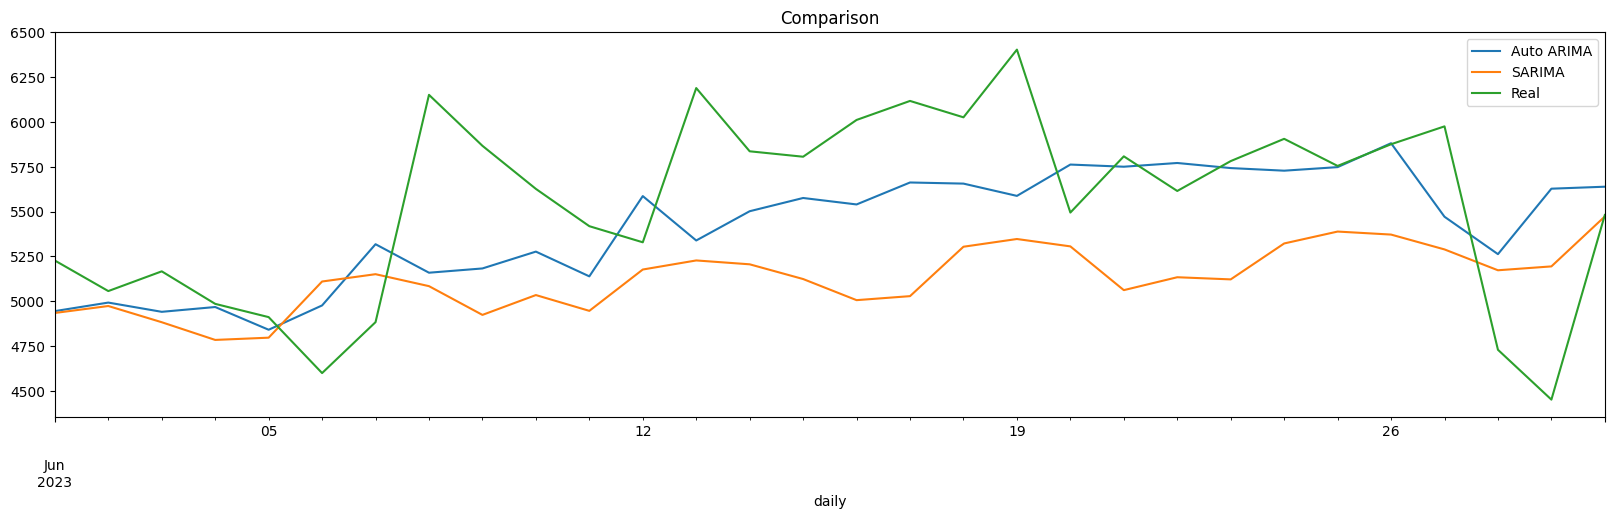

In [149]:
predictions.plot(figsize=(20,5))

plt.title('Comparison')
plt.legend(['Auto ARIMA','SARIMA','Real'])
plt.show()

### RMSE Metric

In [156]:
rmse_autoarima = np.sqrt(mean_squared_error(predictions.test, predictions['autoarima']))
rmse_sarima = np.sqrt(mean_squared_error(predictions.test, predictions['sarima']))

print('RMSE Auto ARIMA:', round(rmse_autoarima,2))
print('RMSE SARIMA:', round(rmse_sarima,2))

RMSE Auto ARIMA: 461.74
RMSE SARIMA: 633.08
